In [14]:
import numpy as np
import os
import json
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        annotation_data = json.load(f)
    image_id_to_file = {img['id']: img['file_name'] for img in annotation_data['images']}
    annotations = {image_id_to_file[ann['image_id']]: ann['category_id'] for ann in annotation_data['annotations']}
    return annotations

train_annotations = load_annotations(r'dataset\\train\\_annotations.coco.json')
val_annotations = load_annotations(r'dataset\\valid\\_annotations.coco.json')


In [16]:
def data_generator(directory, annotations, batch_size=16, target_size=(416, 416)):
    files = list(annotations.keys())
    num_files = len(files)
    while True:
        np.random.shuffle(files)
        for offset in range(0, num_files, batch_size):
            batch_files = files[offset:offset+batch_size]
            images = []
            labels = []
            for file in batch_files:
                image_path = os.path.join(directory, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, target_size)
                images.append(image)
                labels.append(annotations[file])
            yield np.array(images) / 255.0, to_categorical(np.array(labels), num_classes=4)


In [17]:
batch_size = 16
train_generator = data_generator(r'dataset\\train', train_annotations, batch_size)
val_generator = data_generator(r'dataset\\valid', val_annotations, batch_size)

In [18]:
steps_per_epoch = len(train_annotations) // batch_size
validation_steps = len(val_annotations) // batch_size


In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(416, 416, 3))
base_model.trainable = False  # 

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
235/235 [==============================] - 44s 183ms/step - loss: 1.3023 - accuracy: 0.3992 - val_loss: 1.0949 - val_accuracy: 0.5804 - lr: 1.0000e-04
Epoch 2/50
235/235 [==============================] - 42s 178ms/step - loss: 1.0280 - accuracy: 0.6182 - val_loss: 0.9306 - val_accuracy: 0.6975 - lr: 1.0000e-04
Epoch 3/50
235/235 [==============================] - 47s 199ms/step - loss: 0.8918 - accuracy: 0.6718 - val_loss: 0.8339 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 4/50
235/235 [==============================] - 43s 181ms/step - loss: 0.7969 - accuracy: 0.7228 - val_loss: 0.7717 - val_accuracy: 0.7433 - lr: 1.0000e-04
Epoch 5/50
235/235 [==============================] - 43s 185ms/step - loss: 0.7283 - accuracy: 0.7463 - val_loss: 0.7166 - val_accuracy: 0.7623 - lr: 1.0000e-04
Epoch 6/50
235/235 [==============================] - 42s 180ms/step - loss: 0.6855 - accuracy: 0.7637 - val_loss: 0.6836 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 7/50
235/235 [========

In [22]:
val_annotations = load_annotations(r'dataset\\valid\\_annotations.coco.json')
print(f"Total validation images: {len(val_annotations)}")


Total validation images: 905


In [23]:
batch_size = 16  


val_generator = data_generator(r'dataset\\valid', val_annotations, batch_size)
validation_steps = len(val_annotations) // batch_size
print(f"Validation steps: {validation_steps}")


Validation steps: 56


In [24]:
y_pred = []
y_true = []

for i in range(validation_steps):
    x_batch, y_batch = next(val_generator)
    y_pred_batch = model.predict(x_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)
    
    y_pred.extend(y_pred_classes_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  

y_pred = np.array(y_pred)
y_true = np.array(y_true)


print(f"y_pred shape: {y_pred.shape}, y_true shape: {y_true.shape}")

1/1 [==============================] - 0s 27ms/step
y_pred shape: (896,), y_true shape: (896,)


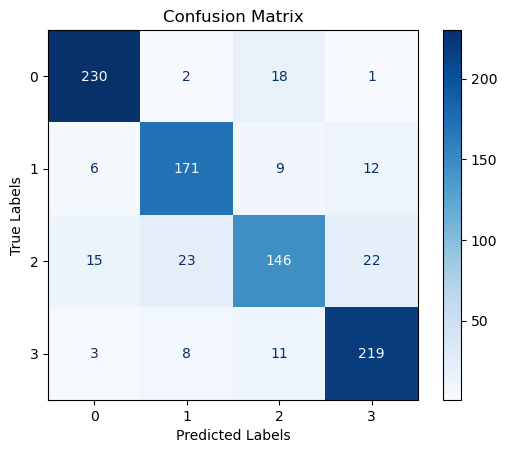

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [26]:
print(f"Total correct predictions: {np.sum(y_true == y_pred)} out of {len(y_true)}")


Total correct predictions: 766 out of 896
